## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [4]:
basedir="/lace/emulator/sim_suites/Australia20/"
emu=gp_emulator.GPEmulator(basedir=basedir,emu_type="polyfit",kmax_Mpc=8,
                           asymmetric_kernel=True,rbf_only=True,
                           drop_tau_rescalings=True,train=True)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.47 seconds


In [5]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Create mock P1D data

Use Lya theory to mimic mock data

In [6]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [7]:
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=0.2)

In [8]:
# check starting point for free parameters
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4


In [9]:
like.get_chi2(values=test_values)

-0.0

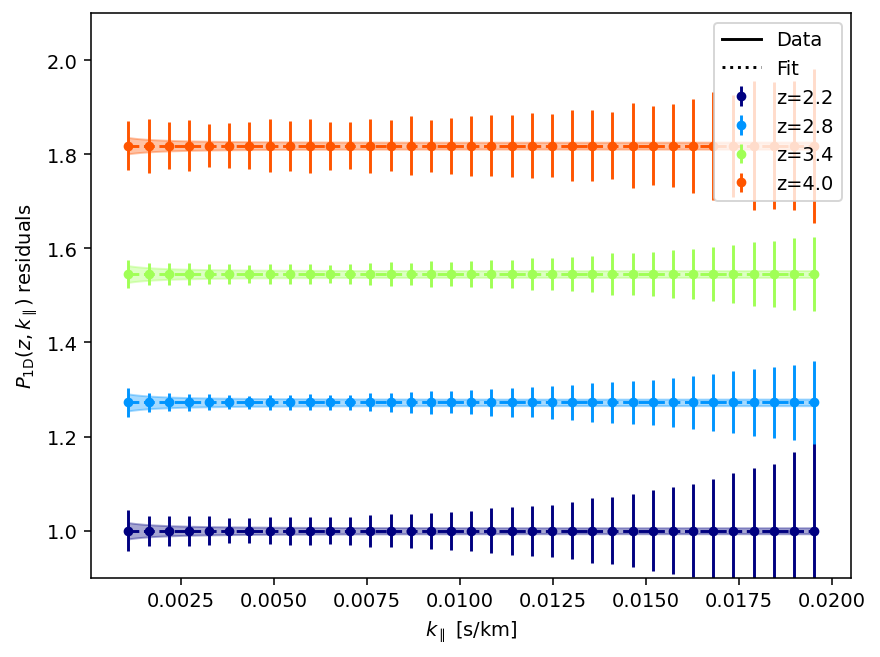

In [10]:
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [12]:
minimizer.minimize(compute_hesse=True)

will run migrad
will compute Hessian matrix


In [13]:
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

0.44633716028872095

In [14]:
like.get_chi2(values=test_values)

-0.0

best-fit values = [0.53056073 0.44398121 0.59674134 0.53806748 0.5914232  0.6454019
 0.52885597 0.39625884 0.53499989 0.49534249]


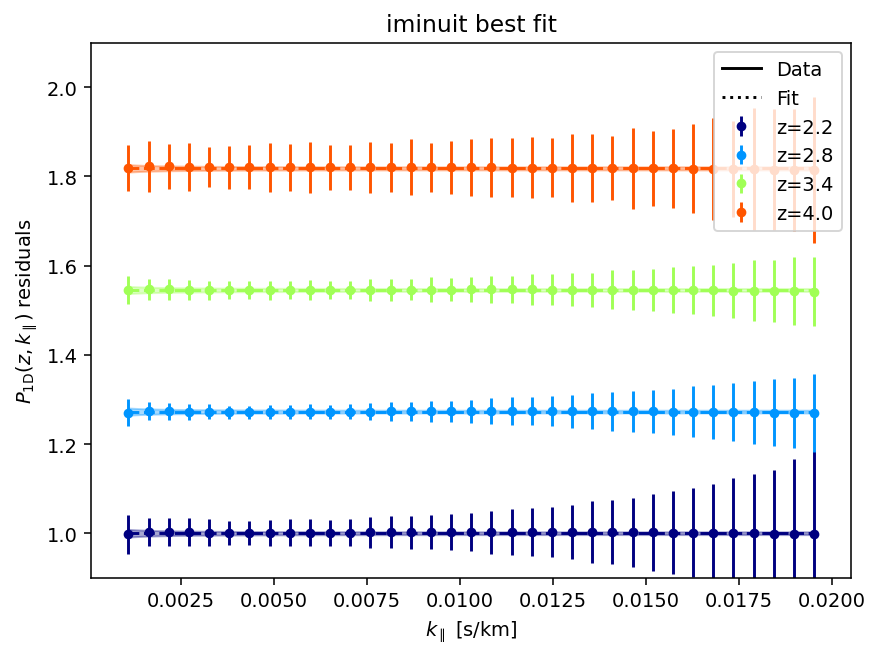

In [15]:
minimizer.plot_best_fit(plot_every_iz=3)

compute true values for As ns


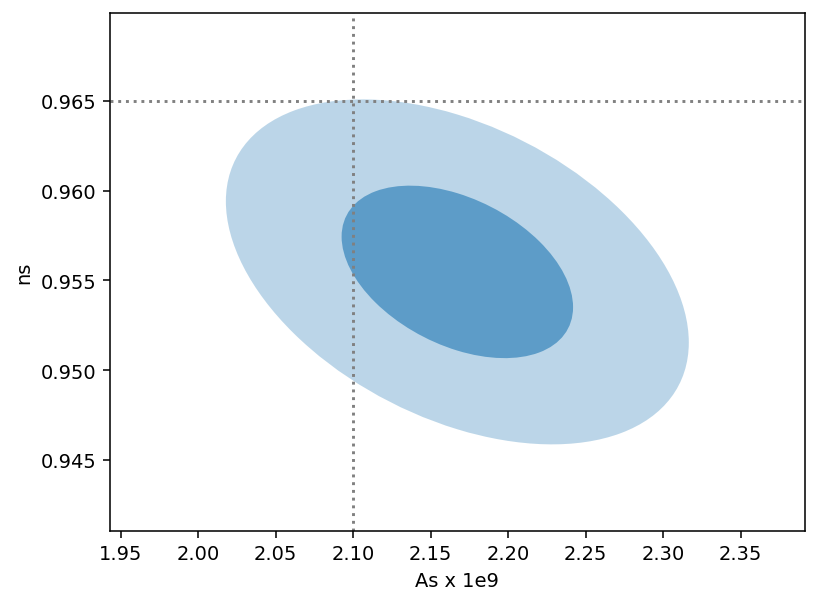

In [16]:
minimizer.plot_ellipses('As','ns')

compute true values for ln_gamma_1 ln_sigT_kms_1


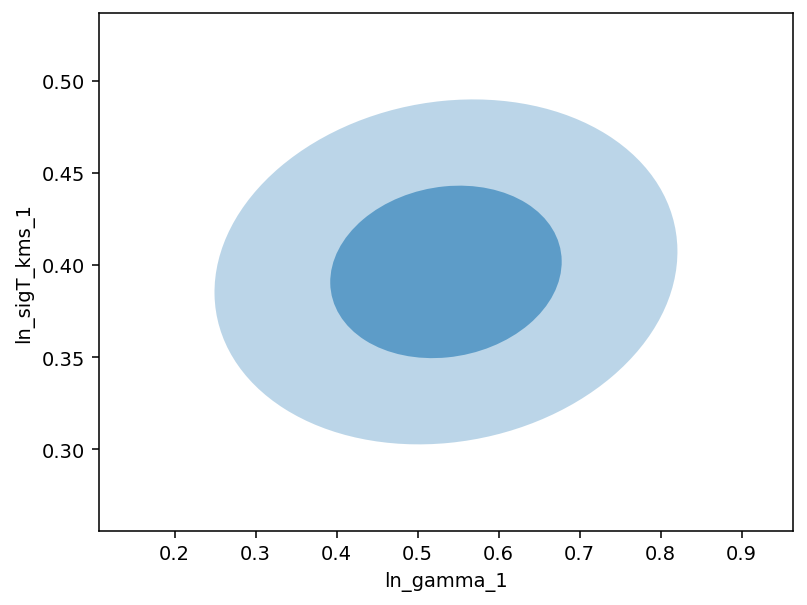

In [17]:
minimizer.plot_ellipses('ln_gamma_1','ln_sigT_kms_1',cube_values=True)

compute true values for ln_tau_0 ln_tau_1


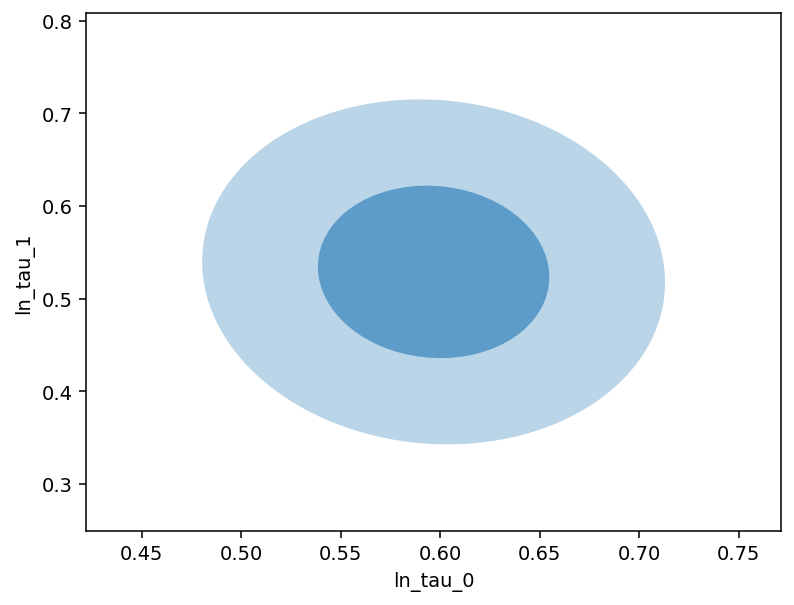

In [18]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [19]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 155.6                      │              Nfcn = 695              │
│ EDM = 3.06e-10 (Goal: 0.0001)    │            time = 9.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.531   │   0.034   │            │            │         │         │       │
│ 1 │ x1   │   0.444   │   0.028   │            │            │         │         │       │
│ 2 │ x2   │   0.60    │   0.06    │            │            │         │         │       │
│ 3 │ x3   │   0.54    │   0.17    │            │            │         │         │       │
│ 4 │ x4   │   0.59    │   0.06    │            │            │         │         │       │
│ 5 │ x5   │   0.65    │   0.07    │            │            │         │         │       │
│ 6 │ x6   │   0.53    │   0.09    │            │            │         │         │       │
│ 7 │ x7   │   0.40    │   0.05    │            │            │         │         │       │
│ 8 │ x8   │   0.53    │   0.14    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.14    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00115 -0.000392  -0.00129  0.000833  0.000281   0.00133  0.000488 -0.000171  0.000529 -0.000375 │
│ x1 │ -0.000392  0.000798 -4.59e-05  -0.00018  0.000184 -0.000807 -0.000345  0.000365  -0.00015 -0.000692 │
│ x2 │  -0.00129 -4.59e-05   0.00338  -0.00155  0.000699   -0.0018 -0.000321   -0.0012 -0.000976  0.000684 │
│ x3 │  0.000833  -0.00018  -0.00155    0.0283   0.00031   0.00247  -0.00868 -0.000367    0.0016  -0.00306 │
│ x4 │  0.000281  0.000184  0.000699   0.00031   0.00359  -0.00175 -0.000764  0.000497   0.00185 -0.000828 │
│ x5 │   0.00133 -0.000807   -0.0018   0.00247  -0.00175   0.00541   0.00153  -0.00153 -3.94e-05  4.41e-05 │
│ x6 │  0.000488 -0.000345 -0.000321  -0.00868 -0.000764   0.00153   0.00866  -0.00097   0.00632   -0.0023 │
│ x7 │ -0.000171  0.000365   -0.0012 -0.000367  0.000497  -0.00153  -0.00097   0.00219  0.000786  0.000269 │
│ x8 │  0.000529  -0.00015 -0.000976    0.0016   0.00185 -3.94e-05   0.00632  0.000786    0.0204  -0.00366 │
│ x9 │ -0.000375 -0.000692  0.000684  -0.00306 -0.000828  4.41e-05   -0.0023  0.000269  -0.00366     0.019 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘